In [1]:
#import dependencies
import warnings 
warnings.filterwarnings('ignore')

#Basic packages
import os
import pandas as pd
import numpy as np
import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import warnings
warnings.filterwarnings('ignore')

## Reading Data

In [2]:
train_df = pd.read_csv(r"C:\Users\susen\Downloads\train.csv")
train_df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [3]:
train_df.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [4]:
#converting Date from string to datetime
train_df['date'] = pd.to_datetime(train_df['date'], format="%Y-%m-%d")

In [5]:
train_df.info()           # no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [6]:
train_df.describe()

,date,store,item,sales
count,913000,913000.000000,913000.000000,913000.000000
mean,2015-07-02 11:59:59.999999744,5.500000,25.500000,52.250287
min,2013-01-01 00:00:00,1.000000,1.000000,0.000000
25%,2014-04-02 00:00:00,3.000000,13.000000,30.000000
50%,2015-07-02 12:00:00,5.500000,25.500000,47.000000
75%,2016-10-01 00:00:00,8.000000,38.000000,70.000000
max,2017-12-31 00:00:00,10.000000,50.000000,231.000000
std,NaN,2.872283,14.430878,28.801144


In [7]:
# Expand dataframe with more useful columns
def expand_df(df):
    data = df.copy()
    
    data['day'] = data.date.dt.day
    data['month'] = data.date.dt.month
    data['year'] = data.date.dt.year
    data['dayofweek'] = data.date.dt.dayofweek
    return data

train_df = expand_df(train_df)
display(train_df)

,date,store,item,sales,day,month,year,dayofweek
0,2013-01-01,1,1,13,1,1,2013,1
1,2013-01-02,1,1,11,2,1,2013,2
2,2013-01-03,1,1,14,3,1,2013,3
3,2013-01-04,1,1,13,4,1,2013,4
4,2013-01-05,1,1,10,5,1,2013,5
...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,27,12,2017,2
912996,2017-12-28,10,50,59,28,12,2017,3
912997,2017-12-29,10,50,74,29,12,2017,4
912998,2017-12-30,10,50,62,30,12,2017,5


In [8]:
train_df = train_df.set_index('date')
train_df.head()

,store,item,sales,day,month,year,dayofweek
date,,,,,,,
2013-01-01,1,1,13,1,1,2013,1
2013-01-02,1,1,11,2,1,2013,2
2013-01-03,1,1,14,3,1,2013,3
2013-01-04,1,1,13,4,1,2013,4
2013-01-05,1,1,10,5,1,2013,5


In [9]:
#sns.lineplot(x="date",y="sales",legend="full",data=train_df)

## Decomposing Time Series

- **The Seasonal component:** A seasonal pattern occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week. Seasonality is always of a fixed and known frequency. A time series can contain multiple superimposed seasonal periods.

- **The Trend component:** A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes a trend is referred to as “changing direction” when it might go from an increasing trend to a decreasing trend.

- **The Cyclical component:** The cyclical component represents phenomena that happen across seasonal periods. Cyclical patterns do not have a fixed period like seasonal patterns do. The cyclical component is hard to isolate and it's often ‘left alone’ by combining it with the trend component.

- **The Noise component:** The noise or the random component is what remains behind when you separate out seasonality and trend from the time series. Noise is the effect of factors that you do not know, or which you cannot measure. It is the effect of the known unknowns, or the unknown unknowns

### Analysing Seasonality

To identify additive or multiplicative model for decomposition-       
There are basically two methods to analyze the seasonality of a Time Series: additive and multiplicative

We use multiplicative models when the magnitude of the seasonal pattern in the data depends on the magnitude of the data. In this situation, trend and seasonal components are multiplied and then added to the error component. It is not linear, can be exponential or quadratic.

On other hand, in the additive model, the magnitude of seasonality does not change in relation to time. In this the effects of the individual factors are differentiated and added to model the data. In this situation, the linear seasonality has the same amplitude and frequency. 

Depending on whether the composition is multiplicative or additive, we’ll need to divide or subtract the trend component from the original time series to retrieve the seasonal and noise components.

The **additive model** is Y[t] = T[t] + S[t] + e[t]

The **multiplicative model** is Y[t] = T[t] * S[t] * e[t]

<Figure size 640x480 with 0 Axes>

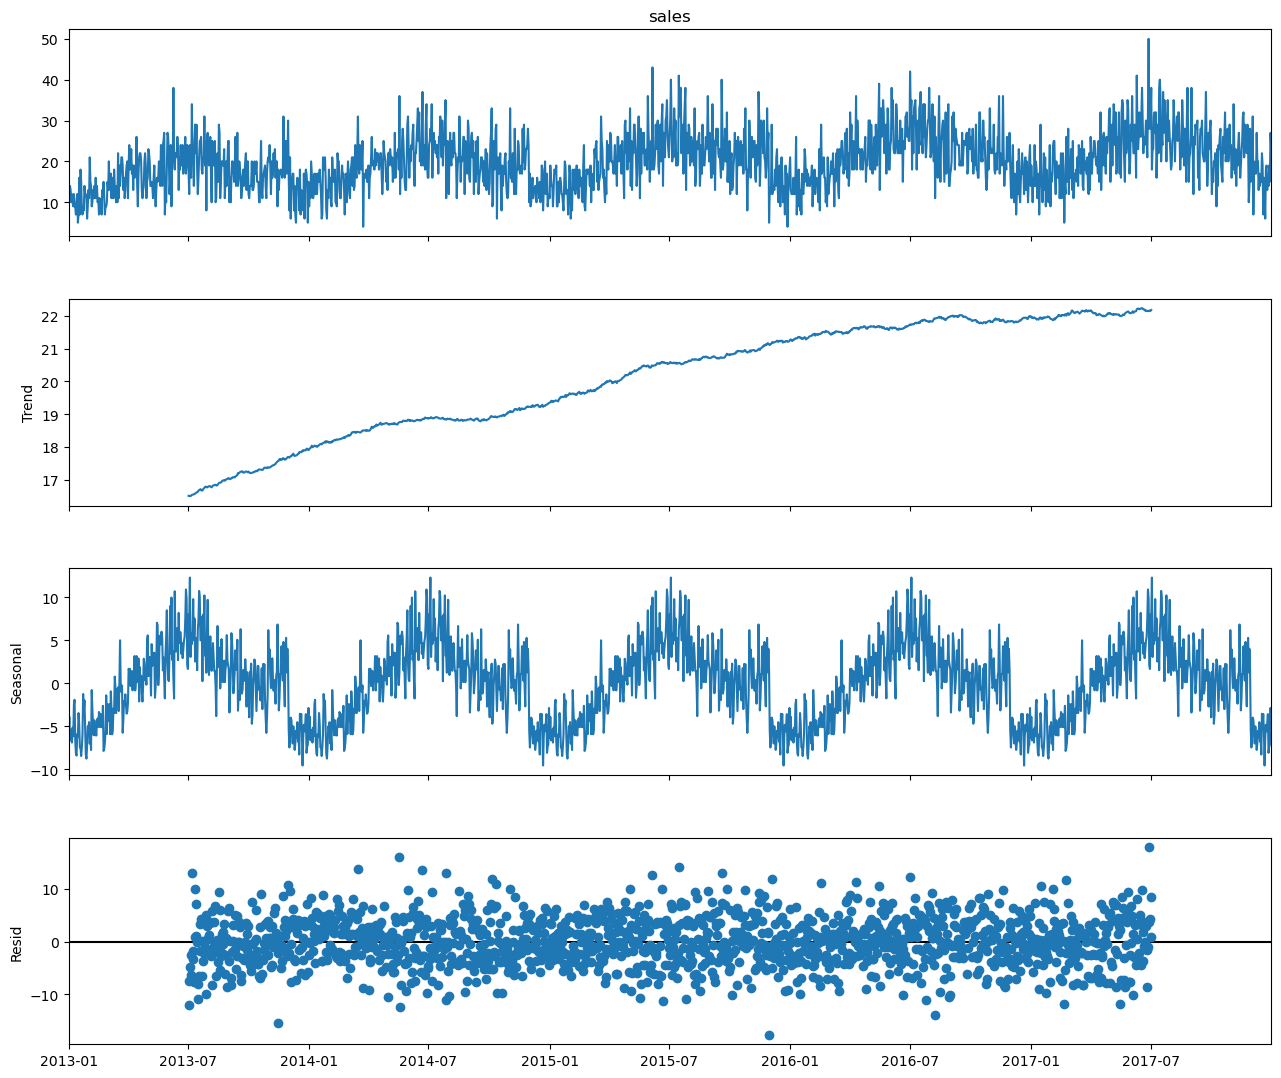

In [10]:
# Lets decompose for data of smaller size. Here I will take data having item and store equal to 1.

train_item1 = train_df[train_df['item']==1]
train_final = train_item1[train_item1['store']==1]

#from statsmodels.tsa.seasonal import seasonal_decompose
result = sm.tsa.seasonal_decompose(train_final['sales'], model='additive', period=365) #Seasonal decomposition using moving averages

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)

## Checking Stationarity

Before applying any statistical model on a Time Series, the series has to be stationary or time invariant, which means that, over different time periods, it should have constant means, constant variance and constant covariance. It means that the data should have constant mean throughout, scattered consistently and should have same frequency throughout.

- The mean of the series should not be a function of time.
- The variance of the series should not be a function of time. This property is known as homoscedasticity. 
- Finally, the covariance of the i th term and the (i + m) th term should not be a function of time.

Here we are going to check the stationarity using 2 methods:

1. **Moving Mean:** Plot the moving average or moving standard deviation to see if it varies with time.

2. **ADCF Test — Augmented Dickey–Fuller test:** This is used to gives us various values that can help in identifying stationarity. The Null hypothesis says that a Time-series is non-stationary. It comprises of a Test Statistics & some critical values for some confidence levels. If the Test statistics is less than the critical values, we can reject the null hypothesis & say that the series is stationary. The ADCF test also gives us a p-value. According to the null hypothesis, lower values of p is better.

### Moving Mean Analysis

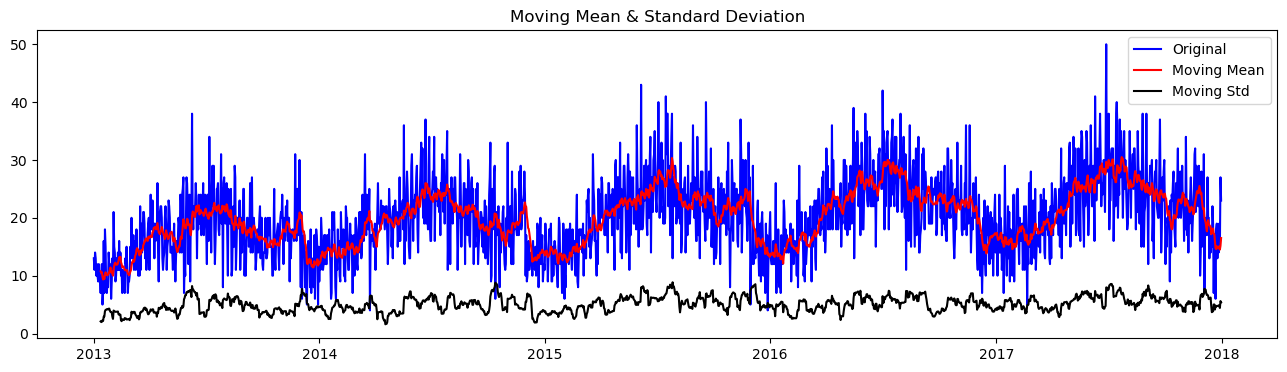

In [11]:
def move_stats(timeseries, window=12, cutoff=0.01):
    # Calculate the moving mean and standard deviation
    movmean = timeseries.rolling(window).mean()
    movstd = timeseries.rolling(window).std()

    # Plot the moving statistics:
    fig = plt.figure(figsize=(16, 4))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movmean, color='red', label='Moving Mean')
    std = plt.plot(movstd, color='black', label='Moving Std')
    plt.legend(loc='best')
    plt.title('Moving Mean & Standard Deviation')
    plt.show()

# Assuming 'train_final' contains your time series data and 'sales' is the column name
move_stats(train_final['sales'])


### Dickey-Fuller test

In [12]:
def dickey_fuller_test(timeseries, window = 12, cutoff = 0.01):
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
dickey_fuller_test(train_final['sales'])

p-value = 0.0361. The series is likely non-stationary.
Test Statistic                   -2.987278
p-value                           0.036100
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


# augmented_dickey_fuller_test

In [13]:
def augmented_dickey_fuller_test(timeseries):
    result = adfuller(timeseries, autolag='AIC', maxlag=20)
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]

    df_output = pd.Series(result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in critical_values.items():
        df_output[f'Critical Value ({key})'] = value

    if p_value < 0.05:  # Using a significance level of 0.05
        stationarity = 'likely stationary'
    else:
        stationarity = 'likely non-stationary'

    print(f'Augmented Dickey-Fuller Test Results:')
    print(df_output)
    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {p_value}')
    print(f'The series is {stationarity}.')

# Example usage:
# Assuming 'train_final['sales']' is your time series data
augmented_dickey_fuller_test(train_final['sales'])


Augmented Dickey-Fuller Test Results:
Test Statistic                   -2.987278
p-value                           0.036100
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64
ADF Statistic: -2.9872778198834222
p-value: 0.03609969398784548
The series is likely stationary.


### Make the time series stationary

date
2013-01-02   -2.0
2013-01-03    3.0
2013-01-04   -1.0
2013-01-05   -3.0
2013-01-06    2.0
Name: sales, dtype: float64


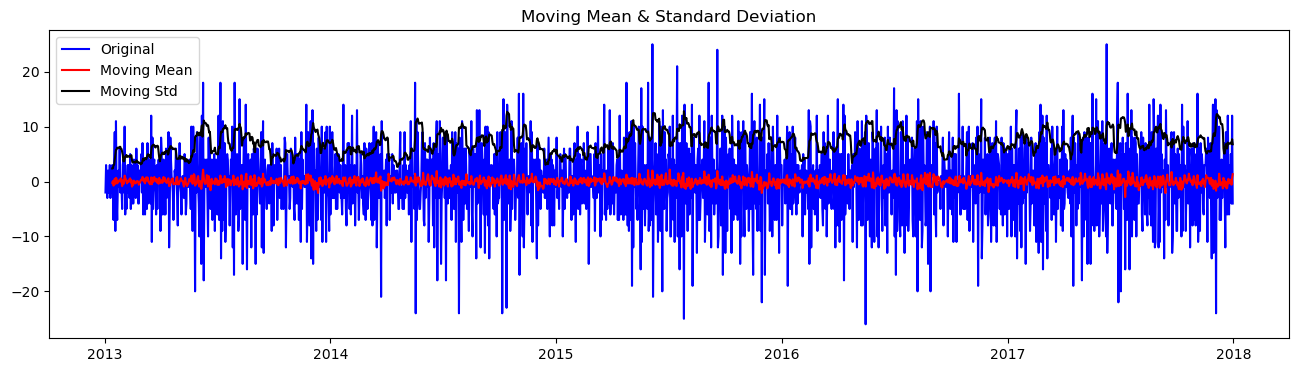

p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.520810e+01
p-value                        5.705031e-28
#Lags Used                     2.000000e+01
Number of Observations Used    1.804000e+03
Critical Value (1%)           -3.433980e+00
Critical Value (5%)           -2.863143e+00
Critical Value (10%)          -2.567624e+00
dtype: float64


In [14]:
first_diff = train_final.sales - train_final.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
print(first_diff.head())

move_stats(first_diff,window = 12, cutoff = 0.01)
dickey_fuller_test(first_diff, window = 12)

#### Now the time series is stationary

### Plot ACF/PACF charts and find optimal parameters:

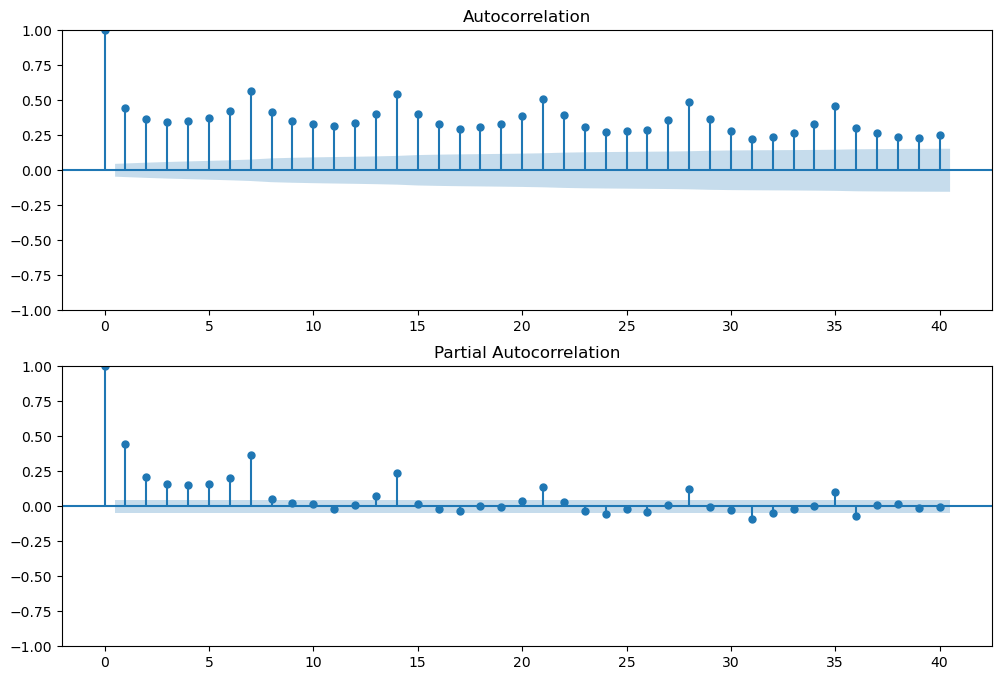

In [15]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_final.sales, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_final.sales, lags=40, ax=ax2)     # lags=40

After diffrencing-

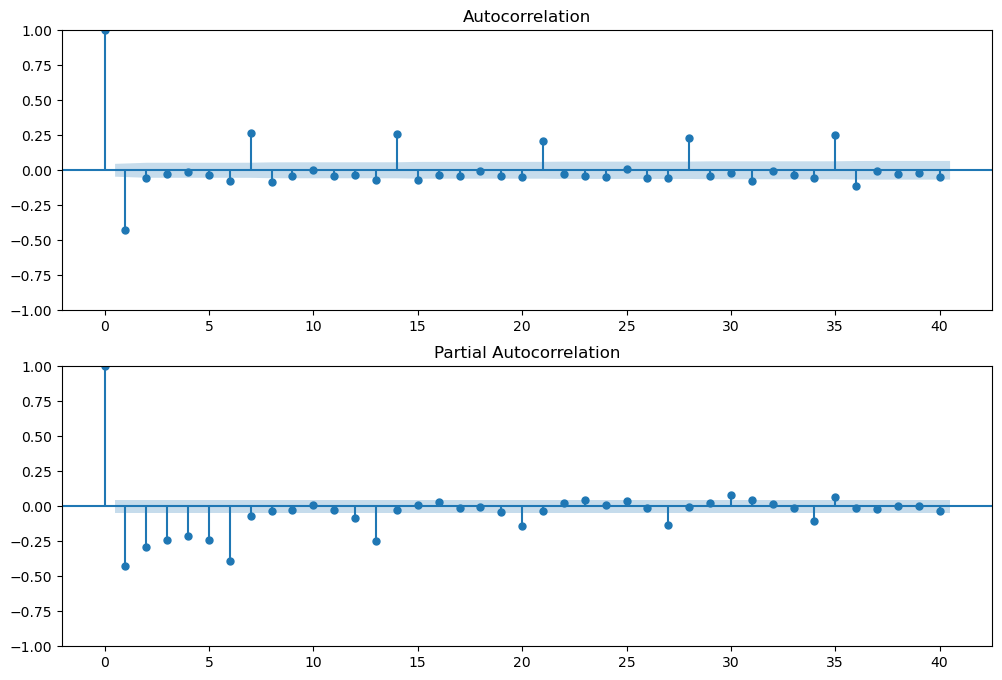

In [16]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

Here we can see the acf and pacf both has a recurring pattern every 7 periods. Indicating a weekly pattern exists.        
Any time you see a regular pattern like that in one of these plots, you should suspect that there is some sort of significant seasonal thing going on. Then we should start to consider SARIMA to take seasonality into accuont

### Determining order p, d, q through ACF/PACF plots:

It's easy to determin I. In our case, we see the first order differencing make the ts stationary. **I = 1**.

AR model might be investigated first with lag length selected from the PACF or via empirical investigation. In our case, it's clearly that within 6 lags the AR is significant. Which means, we can use **AR = 6**

To avoid the potential for incorrectly specifying the MA order (in the case where the MA is first tried then the MA order is being set to 0), it may often make sense to extend the lag observed from the last significant term in the PACF.

What is interesting is that when the AR model is appropriately specified, the the residuals from this model can be used to directly observe the uncorrelated error. This residual can be used to further investigate alternative MA and ARMA model specifications directly by regression.

Assuming an AR(s) model were computed, then I would suggest that the next step in identification is to estimate an MA model with s-1 lags in the uncorrelated errors derived from the regression. The parsimonious MA specification might be considered and this might be compared with a more parsimonious AR specification. Then ARMA models might also be analysed.

### Order of the AR term (p)

In [17]:
import statsmodels.api as sm

# Assuming 'train_final' is your time series data
# Assuming you want to fit an ARIMA(6, 1, 7) model
arima_model = sm.tsa.ARIMA(train_final.sales, order=(7, 1, 0)).fit()

# Print the summary of the ARIMA model
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1826
Model:                 ARIMA(7, 1, 0)   Log Likelihood               -5593.149
Date:                Wed, 06 Dec 2023   AIC                          11202.298
Time:                        15:22:03   BIC                          11246.372
Sample:                    01-01-2013   HQIC                         11218.556
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8448      0.023    -36.992      0.000      -0.890      -0.800
ar.L2         -0.7868      0.028    -28.239      0.000      -0.841      -0.732
ar.L3         -0.7334      0.030    -24.252      0.0

Analyze the result              
To see how our first model perform, we can plot the residual distribution. See if it's normal dist. And the ACF and PACF. For a good model, we want to see the residual is normal distribution. And ACF, PACF has not significant terms.

In [18]:
# arima_model = sm.tsa.ARIMA(train_final.sales, (7,1,0)).fit(disp=False)
# print(arima_model.summary())

In [19]:
# arima_model = sm.tsa.ARIMA(train_final.sales, (6,1,1)).fit(disp=False)
# print(arima_model.summary())

NormaltestResult(statistic=15.420788807496022, pvalue=0.00044814469232786874)


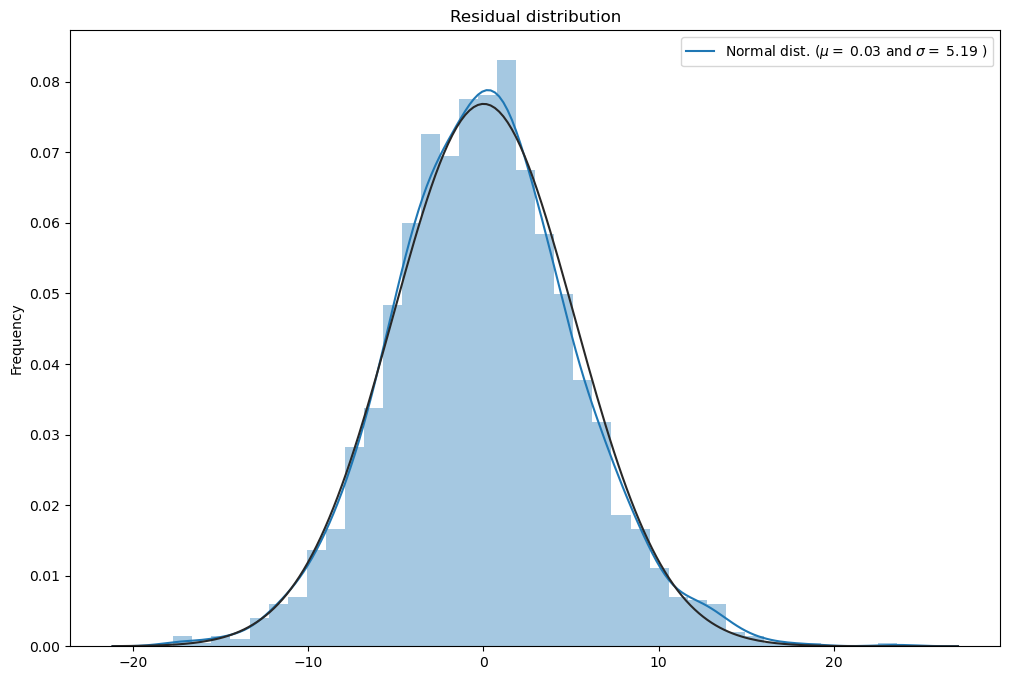

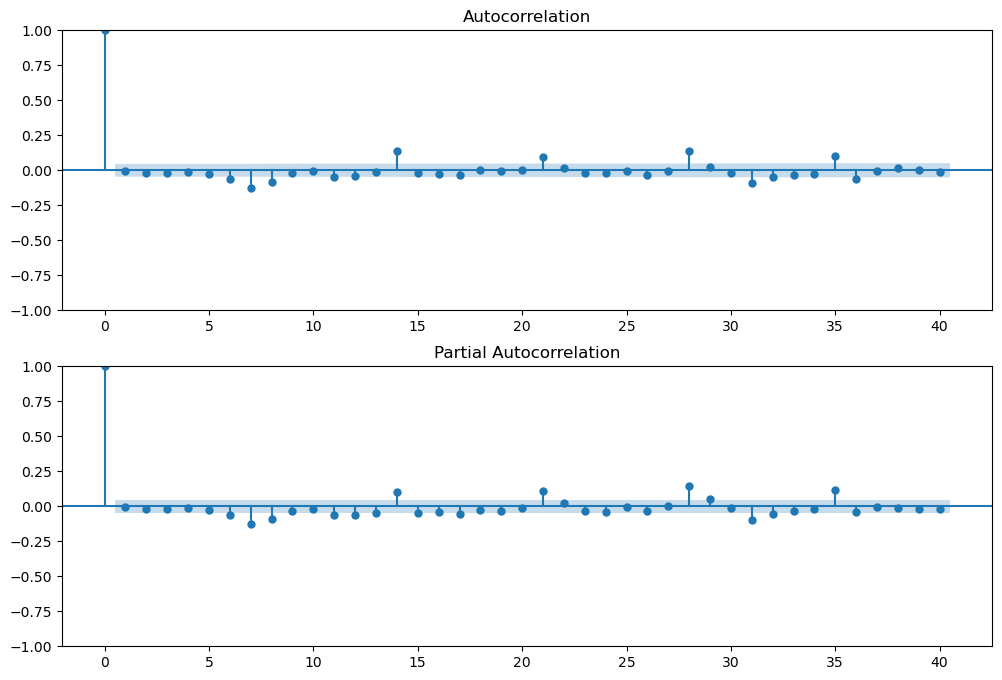

In [20]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_model.resid
print(normaltest(resid))


fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats


(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')



fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_model.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_model.resid, lags=40, ax=ax2)

Although the graph looks very like a normal distribution. But it failed the test. Also we see a recurring correlation exists in both ACF and PACF. So we need to deal with seasonality.

### Prediction using ARIMA Model
Take the last 30 days in training set as validation data

<Axes: xlabel='date'>

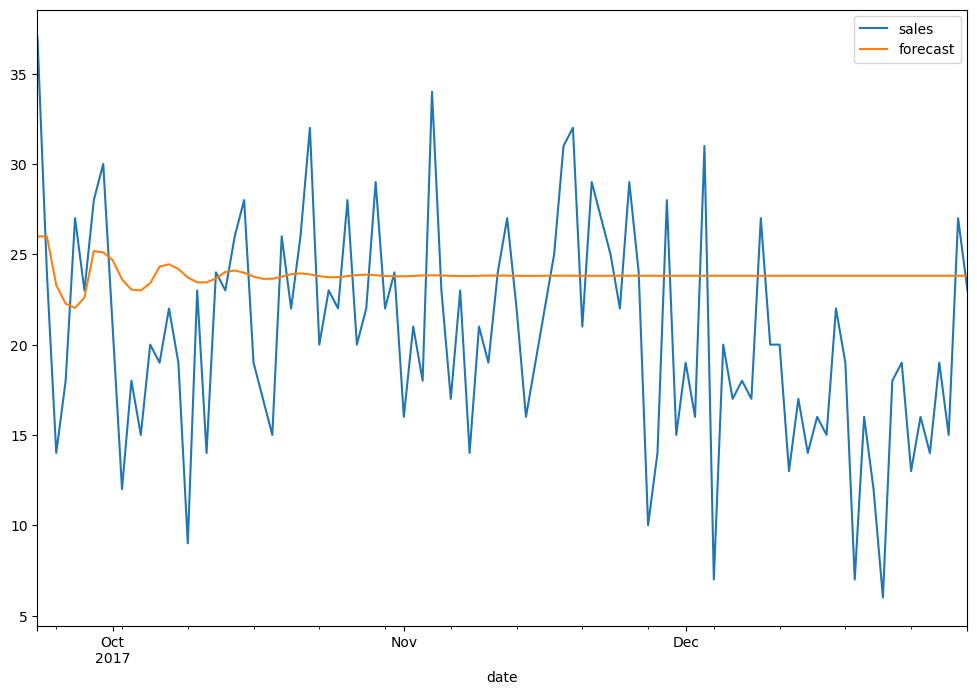

In [21]:
start_index = 1726
end_index = 1826
train_df['forecast'] = arima_model.predict(start = start_index, end= end_index, dynamic= True)  
train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

### Consider seasonality affect by SARIMA¶

In [22]:
# Now we will use SARIMAX

sarima_model = sm.tsa.statespace.SARIMAX(train_final.sales, trend='n', order=(6,1,0)).fit()
print(sarima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1826
Model:               SARIMAX(6, 1, 0)   Log Likelihood               -5597.679
Date:                Wed, 06 Dec 2023   AIC                          11209.359
Time:                        15:22:05   BIC                          11247.924
Sample:                    01-01-2013   HQIC                         11223.585
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8174      0.021    -39.063      0.000      -0.858      -0.776
ar.L2         -0.7497      0.025    -30.480      0.000      -0.798      -0.702
ar.L3         -0.6900      0.026    -26.686      0.0

NormaltestResult(statistic=16.742690143640854, pvalue=0.00023140408919445114)


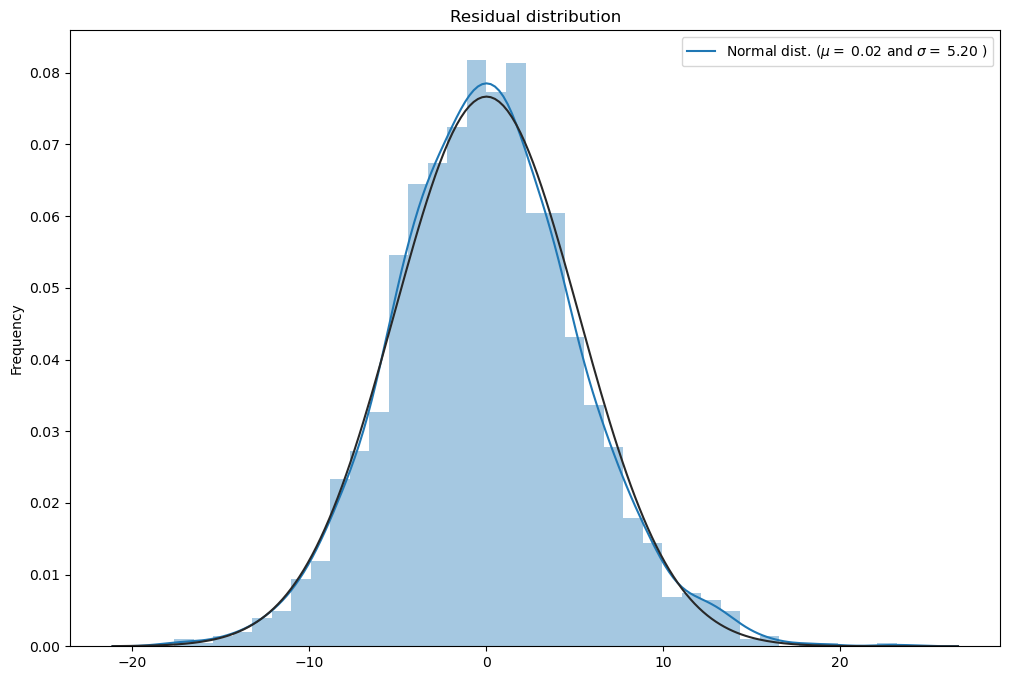

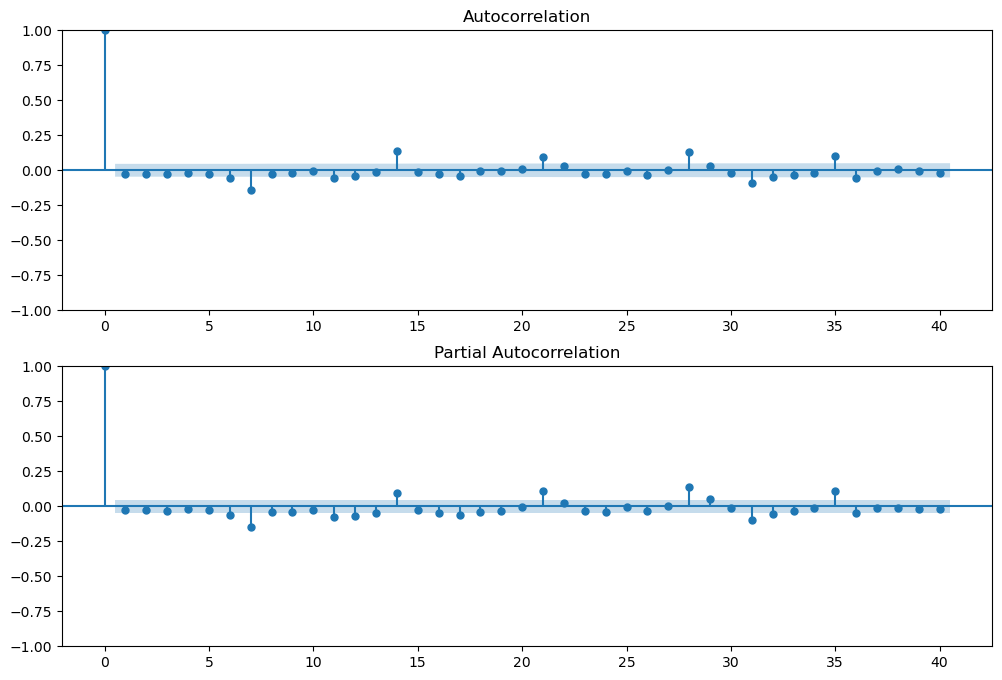

In [23]:
resid = sarima_model.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)
  
sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats


(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarima_model.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarima_model.resid, lags=40, ax=ax2)

### Prediction using SARIMA Model
Take the last 30 days in training set as validation data

<Axes: xlabel='date'>

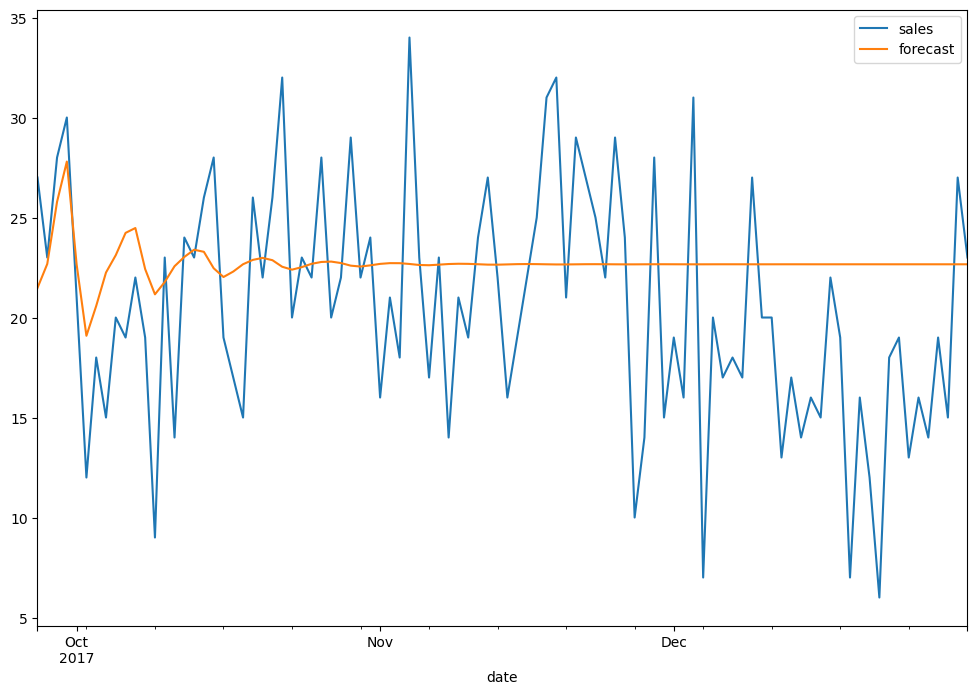

In [24]:
start_index = 1730
end_index = 1826
train_df['forecast'] = sarima_model.predict(start = start_index, end= end_index, dynamic= True)  
train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

We can see that this model is better than simple ARIMA model.

In [25]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [26]:
smape_kun(train_df[1730:1825]['sales'],train_df[1730:1825]['forecast'])

MAPE: 33.01 % 
SMAPE: 25.07 %


In [27]:
!pip install gradio

In [28]:
!pip install --upgrade fastapi typing-extensions
!pip install typing-extensions==<desired_version_number>


The syntax of the command is incorrect.


In [29]:
print(train_df.columns)

Index(['store', 'item', 'sales', 'day', 'month', 'year', 'dayofweek',
       'forecast'],
      dtype='object')


In [30]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import gradio as gr

# Assuming 'train_df' is your dataset
def forecast_sales(start_date, end_date, store, item):
    try:
        # Convert text inputs to datetime objects
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        
        # Filter data based on store and item
        subset = train_df[(train_df['store'] == int(store)) & (train_df['item'] == int(item))]
        
        # Filter data based on date range
        subset = subset[(subset.index >= start_date) & (subset.index <= end_date)]
        
        # Prepare features and target
        X = subset[['store', 'item']]  # Add more features like 'date' if needed
        y = subset['sales']
        
        # Create and fit a linear regression model
        regression_model = LinearRegression()
        regression_model.fit(X, y)
        
        # Prepare data for prediction (assuming predicting for a single date)
        prediction_data = [[int(store), int(item)]]  # Add date if required
        
        # Make predictions using the regression model
        forecast_values = regression_model.predict(prediction_data)
        
        return forecast_values.tolist()  # Convert to list for Gradio

    except Exception as e:
        return str(e)

# Gradio interface
iface = gr.Interface(
    fn=forecast_sales,
    inputs=[
        gr.Textbox(type="text", label="Start Date (YYYY-MM-DD)"),
        gr.Textbox(type="text", label="End Date (YYYY-MM-DD)"),
        gr.Number(label="Store"),
        gr.Number(label="Item")
    ],
    outputs=gr.Textbox(type="text", label="Sales Forecast")
)

iface.launch(share=True)

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://6f3139f20cb107cdd7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
